In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numba import njit

In [2]:
# Please see process_L2_normalization in https://github.com/nkaz001/data-tardis/blob/master/tardis-process.ipynb
#
# x[0] price of a level in the order book
# x[1] quantity of a level in the order book
#
# buy = sum(map(lambda x: x[1], filter(lambda x: x[0] > mid * (1 - p), bid.iteritems())))
# sell = sum(map(lambda x: x[1], filter(lambda x: x[0] < mid * (1 + p), ask.iteritems())))
# imbalance = (buy - sell) / (buy + sell)
# 
# When not considering skew, this strategy does 
# Buy if imbalance is greater than a given threshold +T
# Sell if imbalance is less than a given threshold -T

In [3]:
df = pd.read_pickle('data2')

In [4]:
@njit
def predict_njit(fee_, A, B, half_spread, max_position, X, imbalance):
    tick_size = 0.5
    running_qty = 0
    static_equity = 0
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 100
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    volume = 4
    best_bid = 5
    best_ask = 6
    #imbalance = 7
    for row in X:
        # Check if the orders are filled:
        # the bid order is considered filled if a trade happened below the order price.
        # the ask order is considered filled if a trade happened above the order price.
        # 
        # PnL calculation: 
        # BitMEX XBTUSD is the Inverse Swap contract, please see https://www.bitmex.com/app/perpetualContractsGuide#Contract-Summary
        #if (new_bid > row[low] or (new_bid == row[low] and new_bid == row[best_ask])) and row[volume] > 0:
        if new_bid > row[low] and row[volume] > 0:
            running_qty += order_qty
            static_equity += order_qty / new_bid
            fee += order_qty / new_bid * fee_    
        #if (new_ask < row[high] or (new_ask == row[high] and new_ask == row[best_bid])) and row[volume] > 0:
        if new_ask < row[high] and row[volume] > 0:
            running_qty -= order_qty
            static_equity -= order_qty / new_ask
            fee += order_qty / new_ask * fee_ 
        # equity.append(static_equity - running_qty / row[close] - fee)
        equity.append(static_equity * row[close] - running_qty - fee * row[close])
        running_qty_.append(running_qty)
        # Consider hedging current Bitcoin holding 
        x = running_qty + equity[-1]
        skew = B * x / max_position * -1
        quote_mid_price = row[close] + A * row[imbalance]# + skew
        # Limit the price of orders to best bid/ask in order not to take liquidity. (Due to fee)
        new_bid = np.minimum(np.minimum(np.round(quote_mid_price * (1 - half_spread) / tick_size) * tick_size, row[close] - tick_size), row[best_bid])
        new_ask = np.maximum(np.maximum(np.round(quote_mid_price * (1 + half_spread) / tick_size) * tick_size, row[close] + tick_size), row[best_ask])
        # As BitMEX XBTUSD is the Inverse Swap contract, the maximum position size is fixed in Dollar.
        if x > max_position:
            new_bid = np.nan
        if x < -max_position:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, fee=None, max_position=None, A=None, B=None, half_spread=None, imbalance=None):
        self.fee = fee
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        
    def set_params(self, A, B, half_spread, imbalance):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        return self
        
    def get_params(self, deep=True):
        return { 'fee': self.fee, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread, 'imbalance': self.imbalance }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        equity, running_qty = predict_njit(self.fee, self.A, self.B, self.half_spread, self.max_position, X, self.imbalance)
        return equity, running_qty
    
    def score(self, X):
        equity, r = self.predict(X)
        returns = (pd.Series(equity).diff() / self.max_position).fillna(0)
#         bm_returns = pd.Series(X[:, 3]).pct_change().fillna(0)
#         returns_ = returns - bm_returns
        return np.divide(returns.mean(), returns.std())

In [5]:
train = df[(df.index >= '2020-7-1') & (df.index < '2021-7-1')]
valid = df[df.index < '2020-7-1']

In [6]:
#parameters = { 'A': np.linspace(0.01, 1, 100), 'B': np.linspace(0.01, 1, 100), 'half_spread': np.linspace(0.001, 0.01, 10) }
#search = GridSearchCV(Backtest(10000, 10000), parameters)
#search.fit(df)

#param_dist = { 'A': stats.uniform(50, 500), 'B': stats.uniform(1, 50), 'half_spread': stats.uniform(0, 0.001), 'imbalance': np.arange(4, 13) }
#param_dist = { 'A': stats.uniform(1, 100), 'B': stats.uniform(1, 100), 'half_spread': stats.uniform(0.001, 0.01), 'imbalance': np.arange(7, 16) }
param_dist = { 'A': stats.uniform(100, 1000), 'B': stats.uniform(10, 500), 'half_spread': stats.uniform(0.0005, 0.01), 'imbalance': np.arange(7, 16) }
search = RandomizedSearchCV(Backtest(0.00075, 10000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=8)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 6307200, 6307201, 6307202]),
                        array([      0,       1,       2, ..., 6307200, 6307201, 6307202]))],
                   estimator=<__main__.Backtest object at 0x7f2b050d0e50>,
                   n_iter=1000, n_jobs=8,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b050d0e90>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b050b90d0>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2b050b9250>,
                                        'imbalance': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15])},
                   verbose=1)

In [7]:
# v1.4 params
#search.best_params_ = { 'A': 538.8616407073022, 'B': 29.664684844992756, 'half_spread': 0.0008181141493246589, 'imbalance': 7 }
#search.best_estimator_.set_params(**{ 'A': 538.8616407073022, 'B': 29.664684844992756, 'half_spread': 0.0008181141493246589, 'imbalance': 7 })
# Optimized with full taker fee on Aug. 4, 2021
search.best_params_ = { 'A': 756.7192719328365, 'B': 162.39762097791888, 'half_spread': 0.0031447851763598007, 'imbalance': 10 }
search.best_estimator_.set_params(**{ 'A': 756.7192719328365, 'B': 162.39762097791888, 'half_spread': 0.0031447851763598007, 'imbalance': 10 })

In [8]:
search.best_params_

{'A': 756.7192719328365,
 'B': 162.39762097791888,
 'half_spread': 0.0031447851763598007,
 'imbalance': 10}

In [9]:
search.best_estimator_.score(train.values)

0.0012167466699189759

In [10]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

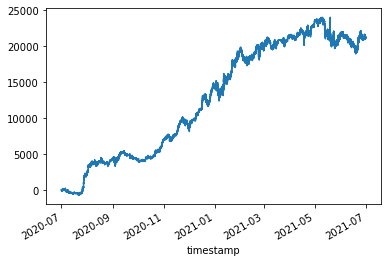

In [11]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

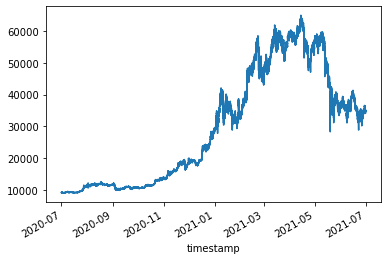

In [12]:
train["close"].plot()

<AxesSubplot:xlabel='timestamp'>

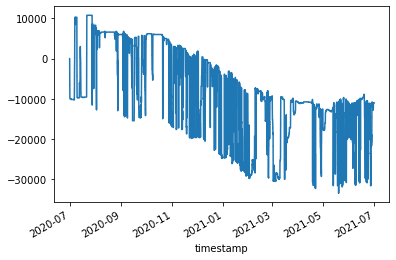

In [13]:
running_qty.plot()

In [14]:
def calc_cagr(begin, final, years):
    if final < 0:
        return (-1) * (((abs(final) + 2 * begin) / begin) ** (1 / years) - 1)
    else:
        return (final / begin) ** (1 / years) - 1

Start date            2020-07-01
End date              2021-06-30
Time period (days)           364
Sharpe Ratio            3.130024
CAGR                    2.137583
Max Daily Drawdown      0.466809
dtype: object


<AxesSubplot:>

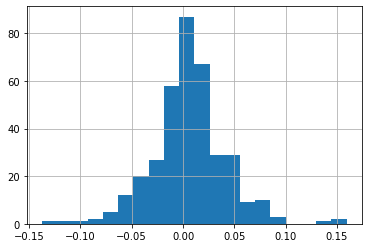

In [15]:
returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
# bm_returns = train['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

returns.hist(bins=20)

In [16]:
equity, running_qty = search.best_estimator_.predict(valid.values)
equity = pd.Series(equity, index=valid.index)
running_qty = pd.Series(running_qty, index=valid.index)

<AxesSubplot:xlabel='timestamp'>

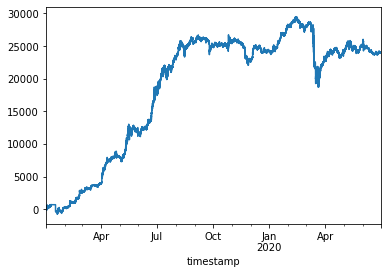

In [17]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

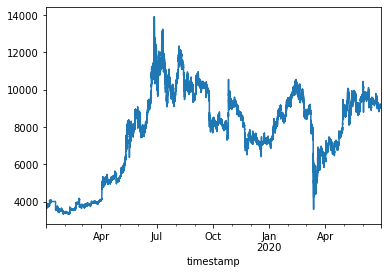

In [18]:
valid["close"].plot()

<AxesSubplot:xlabel='timestamp'>

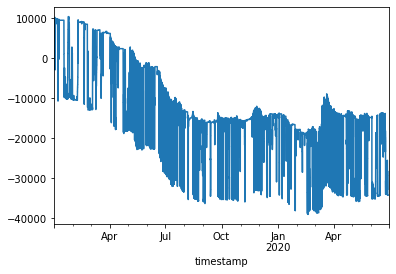

In [19]:
running_qty.plot()

Start date            2019-01-01
End date              2020-06-30
Time period (days)           546
Sharpe Ratio            2.136297
CAGR                    1.266426
Max Daily Drawdown      1.042071
dtype: object


<AxesSubplot:>

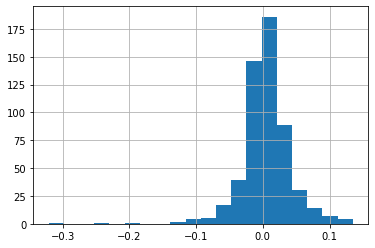

In [20]:
returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
# bm_returns = valid['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

returns.hist(bins=20)

Start date                         2019-01-01
End date                           2022-11-02
Time period (days)                       1400
Train period          2020-07-01 - 2021-06-30
Valid period          2019-01-01 - 2020-06-30
Sharpe ratio                         1.781694
CAGR                                 0.572827
RRR                                  0.549701
Maximum drawdown                     1.042071
dtype: object


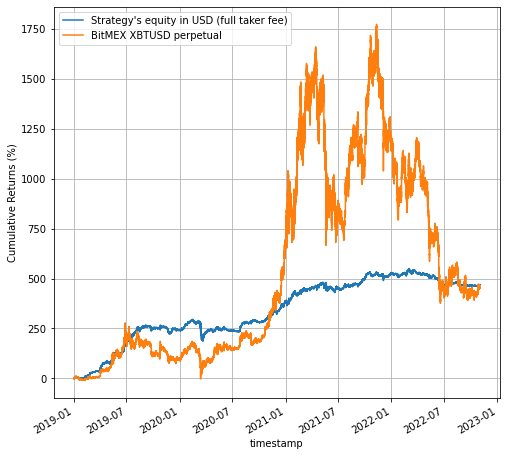

In [21]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
#bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'RRR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = (equity / search.best_estimator_.max_position * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity in USD (full taker fee)", 'BitMEX XBTUSD perpetual'])
ax1.grid()

equity_1d.to_pickle("xbtusd-normalization-takerfee")

<AxesSubplot:xlabel='timestamp'>

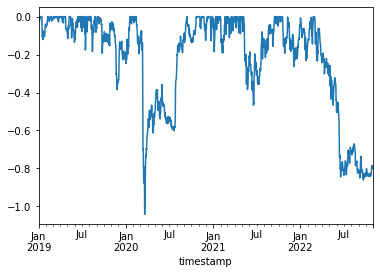

In [22]:
Daily_Drawdown.plot()

<AxesSubplot:xlabel='timestamp'>

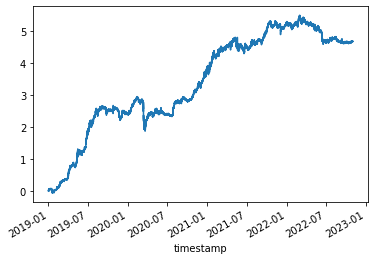

In [23]:
(equity / search.best_estimator_.max_position).plot()

Start date                         2019-01-01
End date                           2022-11-02
Time period (days)                       1400
Train period          2020-07-01 - 2021-06-30
Valid period          2019-01-01 - 2020-06-30
Sharpe ratio                         2.503888
CAGR                                  0.69816
RRR                                  0.813523
Maximum drawdown                     0.858193
dtype: object


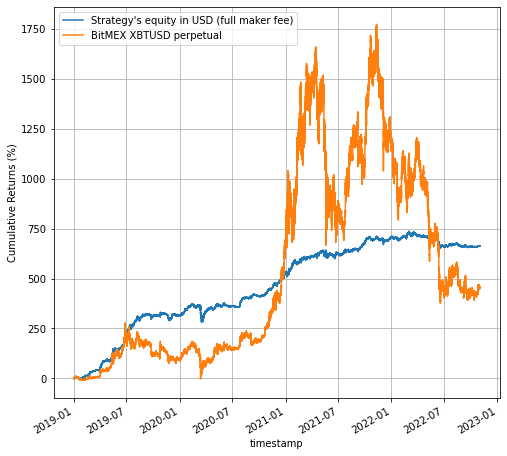

In [24]:
search.best_estimator_.fee = -0.0001 # -0.00025
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
#bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = (equity_1d - Roll_Max) / search.best_estimator_.max_position
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365),
    'RRR': calc_cagr(search.best_estimator_.max_position, search.best_estimator_.max_position + equity[-1], period / 365) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = (equity / search.best_estimator_.max_position * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity in USD (full maker fee)", 'BitMEX XBTUSD perpetual'])
ax1.grid()

equity_1d.to_pickle("xbtusd-normalization-makerfee")

<AxesSubplot:xlabel='timestamp'>

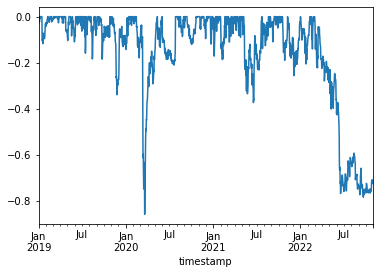

In [25]:
Daily_Drawdown.plot()

<AxesSubplot:xlabel='timestamp'>

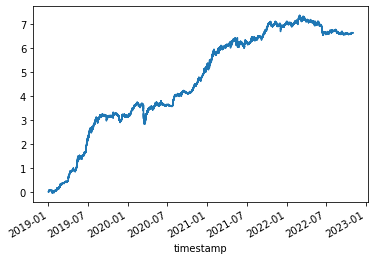

In [26]:
(equity / search.best_estimator_.max_position).plot()